In [1]:
import os
import sys
import json
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import functools

import numpy as np
import math
import random
import scipy

import plotting
import utils
import yaml

2025-03-18 10:45:24.982020: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 10:45:25.131721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742291125.200788   18202 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742291125.222564   18202 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 10:45:25.375835: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
CONFIG_FILE = 'configs/minimal/experiment_config.json'
EMB_SIZE_LOOKUP = {'text-embedding-3-small': 1536,
                   'text-embedding-3-large': 3072,
                   'google/electra-base-generator': 256,
                   'albert-base-v2': 768,
                   'distilbert-base-uncased': 768,
                   'gpt2': 768,
                   'bert-base-uncased': 768,
                   'roberta-base': 768,
                   'bert-large-uncased': 1024,
                   'roberta-large': 1024,
                   'gpt2-large': 1280,
                   'google/electra-base-discriminator': 768
                  }

## Setup

In [3]:
with open(CONFIG_FILE, 'r') as f:
    config = json.load(f)

openai_models = config["openai_models"]
huggingface_models = config["huggingface_models"]
models = huggingface_models + openai_models

In [4]:
results_cav = pd.read_csv('../'+config['results_dir']+config['cav_results_file'])
results_cbm = pd.read_csv('../'+config['results_dir']+config['cbm_results_file'])
results_bias_space = pd.read_csv('../'+config['results_dir']+config['bias_space_results_file'])

In [5]:
assert (results_cav.columns == results_cbm.columns).all() and (results_cav.columns == results_bias_space.columns).all()

In [6]:
results_cav

,protected_attr,dataset (train),dataset (eval),embedder,pooling,group (test),concept (train),F1,Pearson R,Pearson p
0,gender,bios-supervised,bios-supervised,bert-base-uncased,mean,male/female,male/female,0.988802,0.920613,0.00000
1,gender,bios-supervised,jigsaw,bert-base-uncased,mean,any,any,0.169511,NaN,NaN
2,gender,bios-supervised,jigsaw,bert-base-uncased,mean,male vs. rest,male vs. rest,0.169511,0.309016,0.00000
3,gender,bios-supervised,jigsaw,bert-base-uncased,mean,female vs. rest,female vs. rest,0.169511,0.309016,0.00000
4,gender,bios-supervised,jigsaw,bert-base-uncased,mean,male,male,0.169511,0.030355,0.00003
...,...,...,...,...,...,...,...,...,...,...
363,religion,crows_pairs,jigsaw,text-embedding-3-large,NaN,muslim vs. rest,muslim vs. rest,0.142931,0.544967,0.00000
364,religion,crows_pairs,jigsaw,text-embedding-3-large,NaN,jewish vs. rest,jewish vs. rest,0.142931,0.582771,0.00000
365,religion,crows_pairs,jigsaw,text-embedding-3-large,NaN,christian,christian,0.142931,0.592288,0.00000
366,religion,crows_pairs,jigsaw,text-embedding-3-large,NaN,muslim,muslim,0.142931,0.587080,0.00000


In [7]:
results_cbm

,protected_attr,dataset (train),dataset (eval),embedder,pooling,group (test),concept (train),F1,Pearson R,Pearson p
0,gender,bios-supervised,bios-supervised,bert-base-uncased,mean,male,male,0.994259,0.933956,0.0
1,gender,bios-supervised,bios-supervised,bert-base-uncased,mean,female,female,0.994259,0.933951,0.0
2,gender,bios-supervised,jigsaw,bert-base-uncased,mean,any,any,0.278169,NaN,NaN
3,gender,bios-supervised,jigsaw,bert-base-uncased,mean,male vs. rest,male vs. rest,0.278169,0.320270,0.0
4,gender,bios-supervised,jigsaw,bert-base-uncased,mean,female vs. rest,female vs. rest,0.278169,0.320270,0.0
...,...,...,...,...,...,...,...,...,...,...
235,religion,jigsaw,crows_pairs,text-embedding-3-large,NaN,muslim vs. rest,muslim vs. rest,0.907539,0.705448,0.0
236,religion,jigsaw,crows_pairs,text-embedding-3-large,NaN,jewish vs. rest,jewish vs. rest,0.907539,0.725469,0.0
237,religion,jigsaw,crows_pairs,text-embedding-3-large,NaN,christian,christian,0.907539,0.710453,0.0
238,religion,jigsaw,crows_pairs,text-embedding-3-large,NaN,muslim,muslim,0.907539,0.679038,0.0


In [8]:
results_bias_space

,protected_attr,dataset (train),dataset (eval),embedder,pooling,group (test),concept (train),F1,Pearson R,Pearson p
0,gender,/,bios-supervised,bert-base-uncased,mean,male,male,0,0.872468,0.000000e+00
1,gender,/,bios-supervised,bert-base-uncased,mean,female,female,0,0.872468,0.000000e+00
2,gender,/,crows_pairs,bert-base-uncased,mean,any,any,0,0.365159,8.635453e-96
3,gender,/,crows_pairs,bert-base-uncased,mean,male vs. rest,male,0,0.705646,0.000000e+00
4,gender,/,crows_pairs,bert-base-uncased,mean,female vs. rest,female,0,0.705646,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
87,religion,/,crows_pairs,text-embedding-3-large,NaN,muslim vs. rest,muslim,0,0.378535,2.317344e-103
88,religion,/,crows_pairs,text-embedding-3-large,NaN,jewish vs. rest,jewish,0,0.523488,6.896394e-212
89,religion,/,crows_pairs,text-embedding-3-large,NaN,christian,christian,0,0.491936,1.349936e-183
90,religion,/,crows_pairs,text-embedding-3-large,NaN,muslim,muslim,0,0.616496,2.721252e-315


## Process results

In [9]:
# set concept method
res_bias_space = results_bias_space.copy()
res_bias_space['method'] = 'bias space'
res_cav = results_cav.copy()
res_cav['method'] = 'CAV'
res_cbm = results_cbm.copy()
res_cbm['method'] = 'CBM'

# merge results
res_all = pd.concat([res_bias_space, res_cav, res_cbm])
res_all = res_all.reset_index()

# fill empty pooling cells (openai models)
res_all.loc[:,'pooling'] = res_all.loc[:,'pooling'].fillna('unknown')

In [10]:
def get_model_architecture(model_name):
    if type(model_name) != str:
        return model_name
        
    if model_name in openai_models:
        return 'embedder' # presumably also encoder based
    if 'gpt' in model_name:
        return 'decoder'
    else:
        return 'encoder'

def get_model_type(model_name):
    if type(model_name) != str:
        return model_name
        
    if model_name in openai_models:
        return 'embedder'
    if 'gpt' in model_name or 'generator' in model_name:
        return 'generator'
    else:
        return 'discriminator'

res_all['model_type'] = [get_model_type(res_all.loc[i,'embedder']) for i in range(len(res_all))]
res_all['model_architecture'] = [get_model_architecture(res_all.loc[i,'embedder']) for i in range(len(res_all))]

def get_emb_size(model_name):
    # check model's emb size is saved in the lookup
    if not model_name in EMB_SIZE_LOOKUP.keys():
        if model_name in huggingface_models:
            # load model and get size
            lm = get_pretrained_model(model_name, 2, batch_size=1)
            EMB_SIZE_LOOKUP[model_name] = lm.model.config.hidden_size
        else:
            print("cannot query model size for %s, which is not in the list of huggingface models (set size to 0)")
            EMB_SIZE_LOOKUP[model_name] = 0

    return EMB_SIZE_LOOKUP[model_name]

res_all['emb_size'] = [get_emb_size(res_all.loc[i,'embedder']) for i in range(len(res_all))]
res_all

,index,protected_attr,dataset (train),dataset (eval),embedder,pooling,group (test),concept (train),F1,Pearson R,Pearson p,method,model_type,model_architecture,emb_size
0,0,gender,/,bios-supervised,bert-base-uncased,mean,male,male,0.000000,0.872468,0.000000e+00,bias space,discriminator,encoder,768
1,1,gender,/,bios-supervised,bert-base-uncased,mean,female,female,0.000000,0.872468,0.000000e+00,bias space,discriminator,encoder,768
2,2,gender,/,crows_pairs,bert-base-uncased,mean,any,any,0.000000,0.365159,8.635453e-96,bias space,discriminator,encoder,768
3,3,gender,/,crows_pairs,bert-base-uncased,mean,male vs. rest,male,0.000000,0.705646,0.000000e+00,bias space,discriminator,encoder,768
4,4,gender,/,crows_pairs,bert-base-uncased,mean,female vs. rest,female,0.000000,0.705646,0.000000e+00,bias space,discriminator,encoder,768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,235,religion,jigsaw,crows_pairs,text-embedding-3-large,unknown,muslim vs. rest,muslim vs. rest,0.907539,0.705448,0.000000e+00,CBM,embedder,embedder,3072
696,236,religion,jigsaw,crows_pairs,text-embedding-3-large,unknown,jewish vs. rest,jewish vs. rest,0.907539,0.725469,0.000000e+00,CBM,embedder,embedder,3072
697,237,religion,jigsaw,crows_pairs,text-embedding-3-large,unknown,christian,christian,0.907539,0.710453,0.000000e+00,CBM,embedder,embedder,3072
698,238,religion,jigsaw,crows_pairs,text-embedding-3-large,unknown,muslim,muslim,0.907539,0.679038,0.000000e+00,CBM,embedder,embedder,3072


In [11]:
# from a western-centric perspective (leaving white,male,christian as non-marginalized groups)
marginalized_groups = ['F', 'female', 'asian', 'black', 'latino', 'buddhist', 'hindu', 'jewish', 'muslim', 'mental_disability_illness', 'psychiatric_or_mental_illness']

# from a western/ US perspective / groups that appear infrequent in the datasets (TODO confirm and provide than threshold)
minority_groups = ['asian', 'latino', 'buddhist', 'hindu', 'mental_disability_illness', 'psychiatric_or_mental_illness']


## Utils

In [12]:
def aggregate_results(results, sel_cols, target_col):
    grouped_res = results.groupby(sel_cols, as_index=False)[target_col].mean().reset_index()
    grouped_res[target_col+' var'] = results.groupby(sel_cols, as_index=False)[target_col].var()[target_col]
    return grouped_res

In [42]:
def boxplot(results, ax, xcol, ycol, huecol, title, remove_legend=False, add_ylabel=False, ymin=-0.5, ymax=1.0):
    # mark 0 with hline
    ax.hlines(y=0, xmin=-1, xmax=6, linewidth=0.5, color='black')

    # do boxplot
    if huecol is not None:
        sns.boxplot(data=results, x=xcol, y=ycol, hue=huecol, ax=ax)
    else:
        sns.boxplot(data=res_dataset, x=xcol, y=ycol, ax=ax)

    # set title and labels/ change fontsize
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('')
    if add_ylabel:
        ax.set_ylabel(ycol, fontsize=15)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=15)
    
    # set lenged if required, set ylim to make space for legend
    ax.set_ylim(ymin, ymax)
    legend = ax.legend(fontsize=14)
    if remove_legend:
        legend.remove()

def multipot(results, subplot_col, xcol, ycol, huecol, title=None, remove_legend=False, savefile=None):
    # create a subplot for unique value in subplot_col
    subplot_choices = list(set(results.loc[:,subplot_col]))
    fig, axes = plt.subplots(1, len(subplot_choices), figsize=(5*len(subplot_choices), 4))

    # do boxplot for each value in subplot_col
    if len(subplot_choices) == 1:
        boxplot(results, axes, xcol=xcol, ycol=ycol, huecol=huecol, title=subplot_choices[0], add_ylabel=True)
    else:
        for i, val in enumerate(subplot_choices):
            res_filt = results.loc[results[subplot_col] == val]
            boxplot(res_filt, axes[i], xcol=xcol, ycol=ycol, huecol=huecol, title=val, add_ylabel=(i==0))
    if title is not None:
        plt.title(title)
    
    # (save and) show figure
    if savefile is not None:
        if '.eps' in savefile:
            plt.savefig(savefile, format='eps', bbox_inches='tight')
        else:
            plt.savefig(savefile, bbox_inches='tight')
    plt.show()

## 1) Baseline: Linear Concept learning (CAV, CBM)

Report and plot F1-scores for CAV and CBM in the regular concept learning (train-test from same datasets) and concept transfer (to another dataset) setting. The concept learning serves as a baseline as it should reflect the best possible estimation of linear concepts in the language model's embeddings (assuming classifiers converge; given the available data). The concept transfer case shows how robust or dataset-specific the learned concepts are.

### a) Learning and testing on splits of the same dataset

In [14]:
res_cl = res_all[res_all['method'] != 'bias space']

# aggregate results of all groups of the same experiment run
gres = aggregate_results(res_cl, ['method', 'protected_attr', 'dataset (train)', 'dataset (eval)', 'pooling', 'embedder'], 'F1')

# add column to distinguish transfer and non-transfer cases
gres.loc[:, 'exp'] = ['transfer' if gres.loc[i, 'dataset (train)'] != gres.loc[i, 'dataset (eval)'] else '' for i in range(len(gres))]
gres_same_dataset = gres[gres['exp'] != 'transfer']

# summarize results per dataset and transfer/ non transfer
res_per_dataset_transfer = aggregate_results(gres_same_dataset, ['exp', 'dataset (eval)', 'method'], 'F1')
res_per_dataset_transfer

,index,exp,dataset (eval),method,F1,F1 var
0,0,,bios-supervised,CAV,0.990103,0.000027
1,1,,bios-supervised,CBM,0.994363,0.000005
2,2,,jigsaw,CAV,0.321572,0.053749
3,3,,jigsaw,CBM,0.501985,0.020483


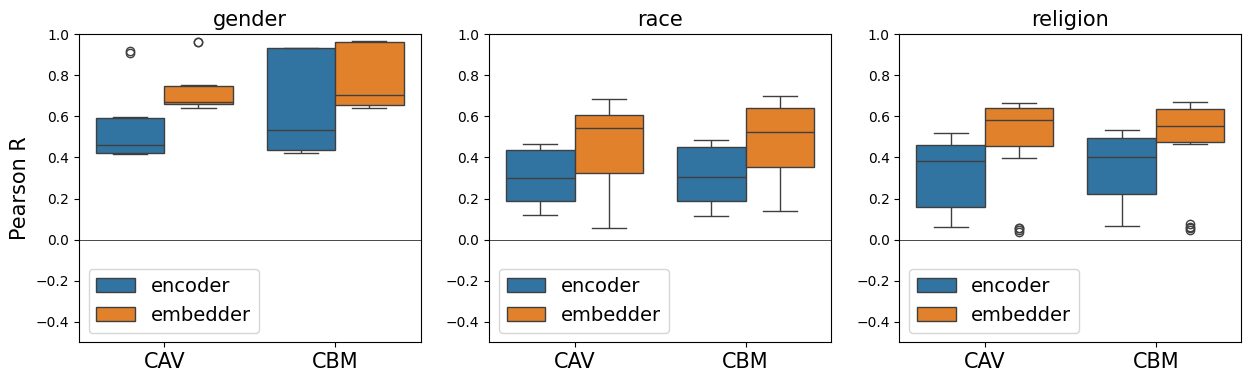

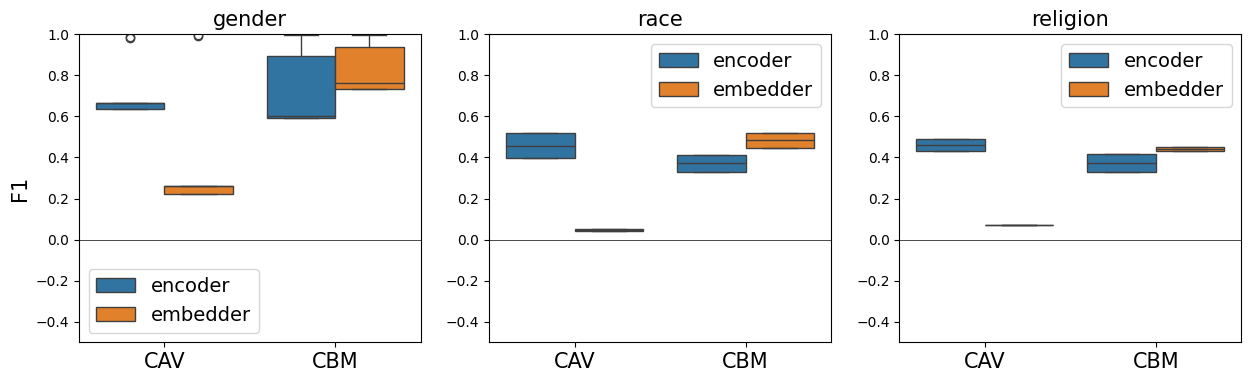

In [15]:
res_cl_same_dataset = res_cl[res_cl['dataset (train)'] == res_cl['dataset (eval)']]

multipot(res_cl_same_dataset, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', remove_legend=False)
multipot(res_cl_same_dataset, subplot_col='protected_attr', xcol='method', ycol='F1', huecol='model_architecture', remove_legend=False)

### b) Cross-dataset transfer

In [17]:
gres_transfer = gres[gres['exp'] == 'transfer']

# summarize results per dataset and transfer/ non transfer
res_per_dataset_transfer = aggregate_results(gres_transfer, ['exp', 'dataset (eval)', 'method'], 'F1')
res_per_dataset_transfer

,index,exp,dataset (eval),method,F1,F1 var
0,0,transfer,bios-supervised,CAV,0.665915,0.096289
1,1,transfer,bios-supervised,CBM,0.105587,0.001096
2,2,transfer,crows_pairs,CAV,0.390032,0.049859
3,3,transfer,crows_pairs,CBM,0.634901,0.038568
4,4,transfer,jigsaw,CAV,0.195209,0.014544
5,5,transfer,jigsaw,CBM,0.279481,0.000119
6,6,transfer,twitterAAE,CAV,0.285099,0.063980
7,7,transfer,twitterAAE,CBM,0.008392,0.000053


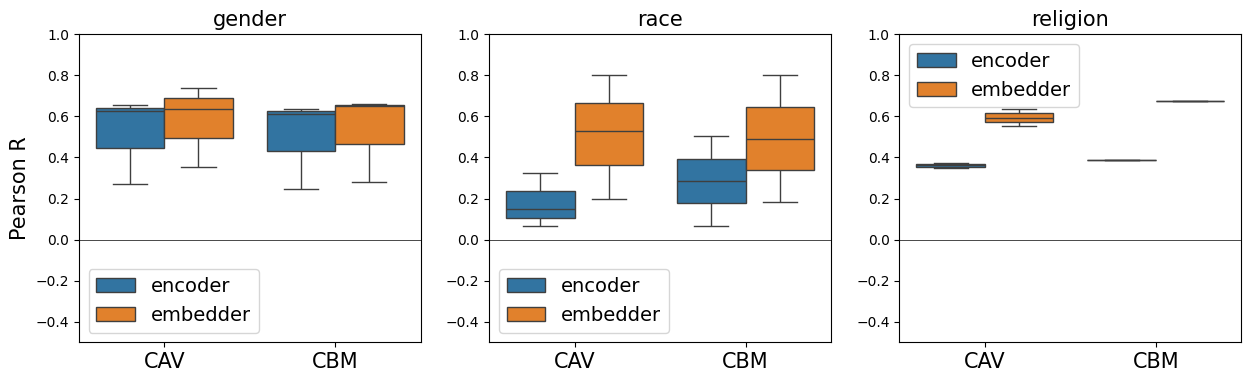

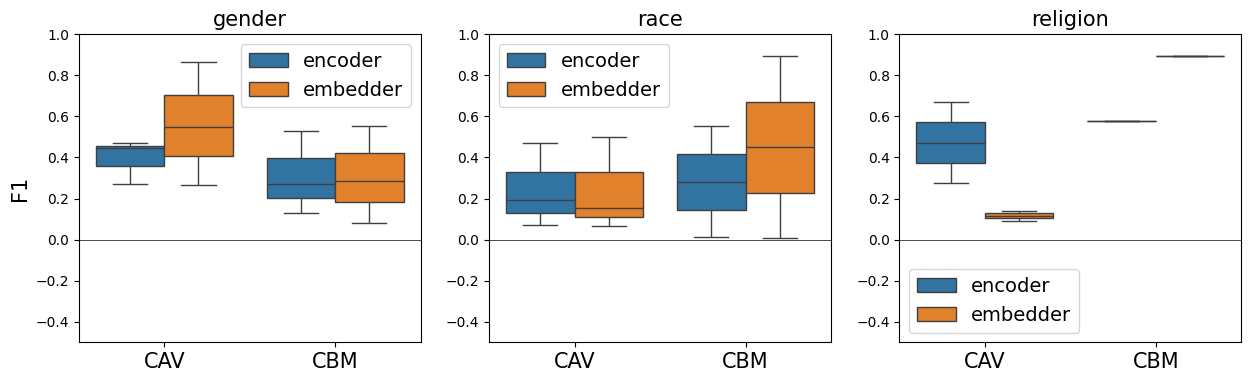

In [32]:
res_cl_transfer = res_cl[res_cl['dataset (train)'] != res_cl['dataset (eval)']]

# aggregate results over dataset first (bc number of rows/ protected groups is different!)
grouped_res_r = res_cl_transfer.groupby(['protected_attr', 'dataset (eval)', 'method', 'model_type','model_architecture'], as_index=False)['Pearson R'].mean().reset_index()
multipot(grouped_res_r, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', remove_legend=False)

grouped_res_f1 = res_cl_transfer.groupby(['protected_attr', 'dataset (eval)', 'method', 'model_type','model_architecture'], as_index=False)['F1'].mean().reset_index()
multipot(grouped_res_f1, subplot_col='protected_attr', xcol='method', ycol='F1', huecol='model_architecture', remove_legend=False)

## 2) Evaluating Bias Space for Concept Retrieval

Comparing Pearson Correlation of Bias Space concepts with CBM and CAV.

### a) Overview over protected attributes.

In [34]:
res_all.columns

Index(['index', 'protected_attr', 'dataset (train)', 'dataset (eval)',
       'embedder', 'pooling', 'group (test)', 'concept (train)', 'F1',
       'Pearson R', 'Pearson p', 'method', 'model_type', 'model_architecture',
       'emb_size'],
      dtype='object')

In [35]:
# aggregate results over groups of the same experiment setup
gres = aggregate_results(res_all, ['protected_attr', 'dataset (train)', 'dataset (eval)', 'embedder', 'pooling', 'method', 'model_architecture', 'model_type', 'emb_size'], 'Pearson R')

In [45]:
gres_same_dataset = gres[(gres['method'] == 'bias space') | (gres['dataset (train)'] == gres['dataset (eval)'])]
gres_transfer = gres[(gres['method'] == 'bias space') | (gres['dataset (train)'] != gres['dataset (eval)'])]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


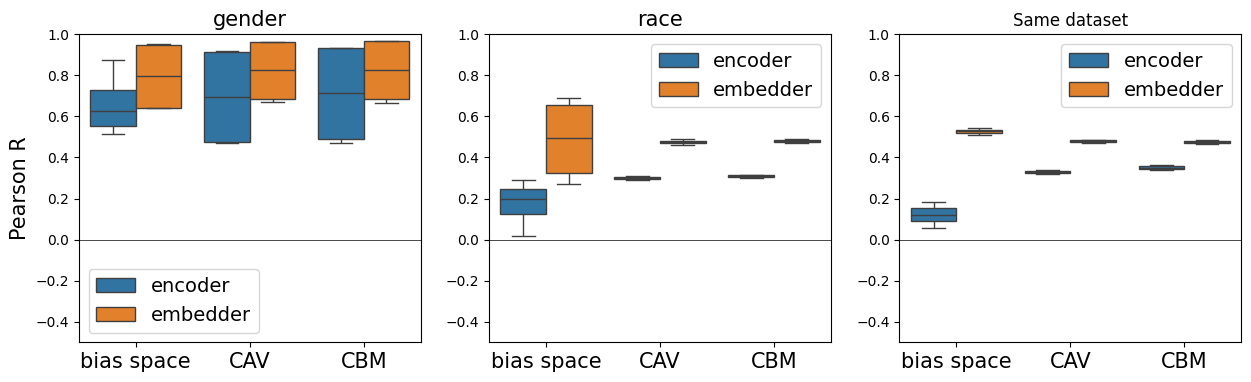

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


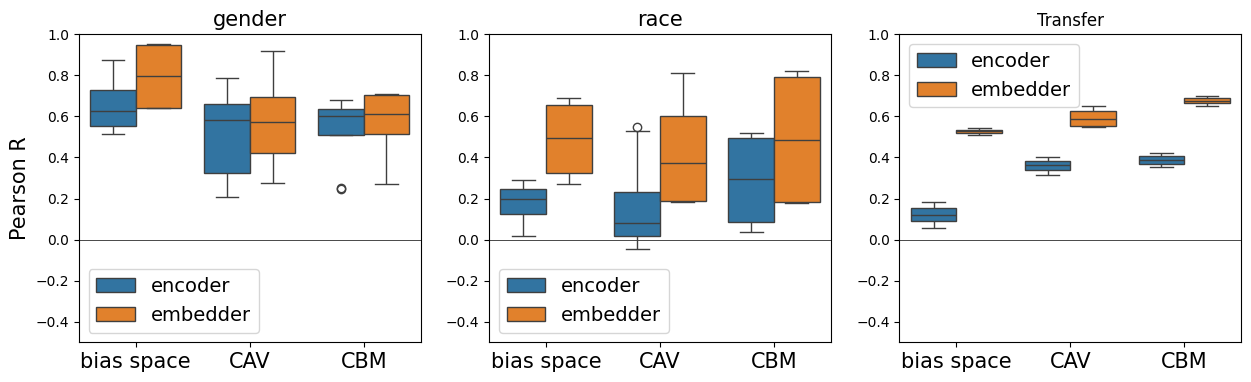

In [47]:
multipot(gres_same_dataset, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', title='Same dataset', remove_legend=False, savefile='plots/esann25/corr.eps')
multipot(gres_transfer, subplot_col='protected_attr', xcol='method', ycol='Pearson R', huecol='model_architecture', title='Transfer', remove_legend=False, savefile='plots/esann25/corr.eps')

### b) Overview over datasets (one plot per attribute)


gender


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


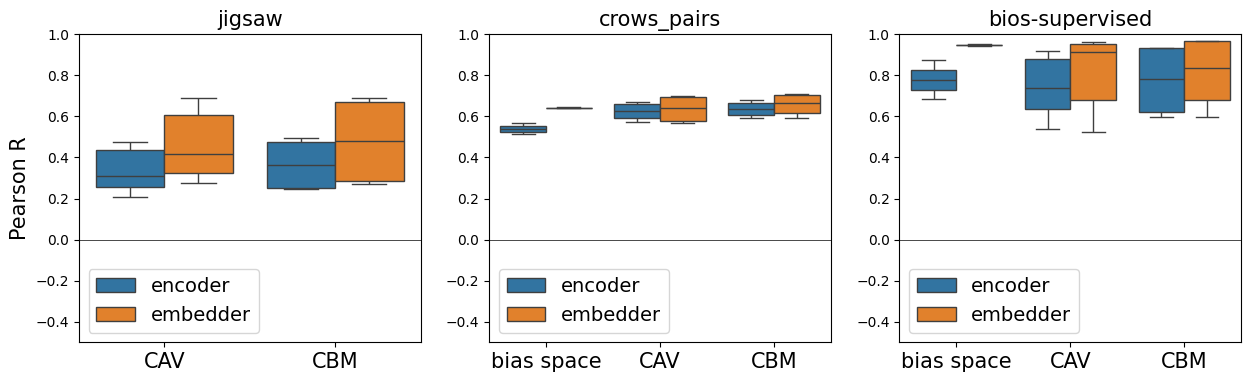


race


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


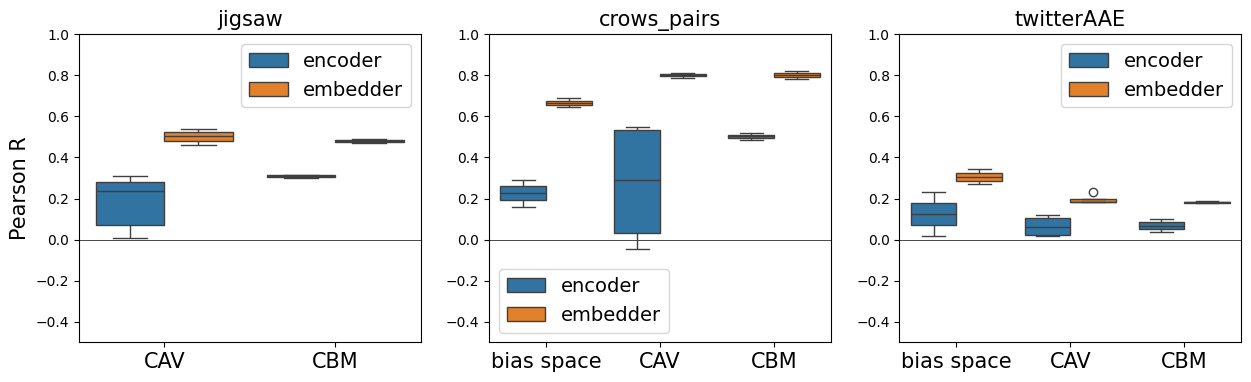

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



religion


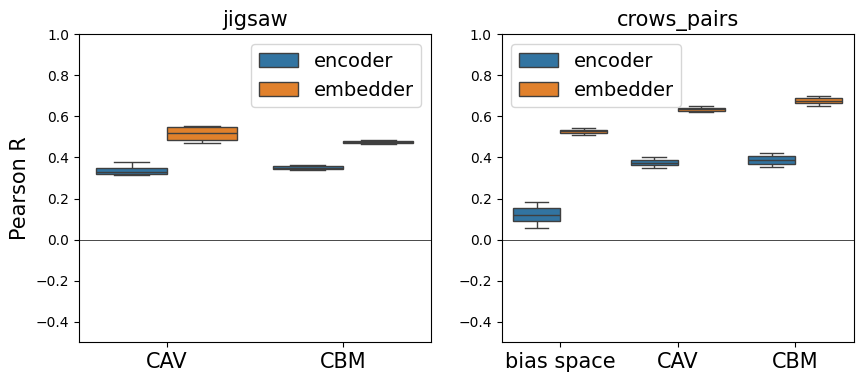

In [37]:
protected_attr = list(set(gres['protected_attr']))
for attr in protected_attr:
    print()
    print(attr)
    res_filt = gres[gres['protected_attr'] == attr]
    multipot(res_filt, subplot_col='dataset (eval)', xcol='method', ycol='Pearson R', huecol='model_architecture', remove_legend=False, savefile=('plots/esann25/corr_%s.eps' % attr))